In [ ]:
Por otro lado, si tengo un proyecto, por de RL. Quiero hacer algunos modelos del mundo para predecir la dinamica de los eventos de mouse y teclado,
asi como de la pantalla y la posicion del cursor. Luego, usarlos para entrenar politicas que traduscan las intrucciones textuales en acciones en la pc
(realizacion de tareas por agentes basados en LLMs y LVMS). 
Todo sto es mucho trabajo, asi que voy de poco en poco. 

entrenar una lstm-mdn
entrenar una lstm
Inclur embbedings para los eventos de mouse y keyboard
Sustituir px,py por las acciones del raton  dx,dy e inlcirlas como tokens en el vocabularios
embbegins, vs one-hot encoding vs my normalization?
grabar mu y sigma para muestrear en lugar de procesar toda la iamgen? 

In [5]:
from monitorlib import load_pcdata
import pandas as pd

data = load_pcdata('data')

def sync_positions(data,sample,i):
     # Cursor positions
     ti = data[sample]['screenshots']['timestamp'][i]
     abs_diff = abs(data[sample]['moves']['timestamp'] - ti)
     closest_index = abs_diff.idxmin()
     px, py = data[sample]['moves']['px'][closest_index], data[sample]['moves']['py'][closest_index]
     return px, py

def sync_MKevents(sample_df, data, sample):
     
     def set_value(sample_df, abs_diff, event):
          closest_index = abs_diff.idxmin()
          if sample_df['mouse_keyboard'][closest_index] != None:
               print('colision')
               # what to do?
               sample_df.loc[closest_index, 'mouse_keyboard'] = event
          else:
               sample_df.loc[closest_index, 'mouse_keyboard'] = event
          

     # Initial values
     sample_df['mouse_keyboard'] = [None for i in range(len(sample_df))]
     timestamps_df = data[sample]['screenshots']['timestamp']

     # Clicks
     for i in range(len(data[sample]['clicks'])):
          ti = data[sample]['clicks']['timestamp'][i]
          button = data[sample]['clicks']['button'][i]
          set_value(sample_df, abs(timestamps_df - ti), button)

     # Scrolls
     for i in range(len(data[sample]['scrolls'])):
          ti = data[sample]['scrolls']['timestamp'][i]
          dy = data[sample]['scrolls']['dy'][i] 
          if dy == 1:
               scroll = 'scroll_down' 
          elif dy == -1:
               scroll = 'scroll_up'
          else:
               scroll = 'what?_scroll'
          set_value(sample_df, abs(timestamps_df - ti), scroll)
   
     # Keyboard events
     for i in range(len(data[sample]['keys'])):
          ti = data[sample]['keys']['timestamp'][i]
          key = data[sample]['keys']['key'][i].strip("'")
          set_value(sample_df, abs(timestamps_df - ti), key)

def sync(data):
     samples = []
     for sample in data.keys():
          sample_df = pd.DataFrame()
          sample_df['img_path'] = [img_path for img_path in data[sample]['screenshots']['img_path']]
          
          # Sync cursor positions to screenshots
          positions = [sync_positions(data,sample,i) for i in range(len(data[sample]['screenshots']))]
          sample_df['px'] = [px for px, _ in positions]
          sample_df['py'] = [py for _, py in positions]

          # Sync mouse and keyboard events to screenshots
          sync_MKevents(sample_df, data, sample)

          samples.append(sample_df)
     return samples


samples = sync(data)
samples[0]

,img_path,px,py,mouse_keyboard
0,data/sample1/0000000000_0.04096198081970215.jpg,570,428,None
1,data/sample1/0000000001_0.12202715873718262.jpg,570,428,None
2,data/sample1/0000000002_0.19535470008850098.jpg,570,428,None
3,data/sample1/0000000003_0.26665711402893066.jpg,570,428,None
4,data/sample1/0000000004_0.3381388187408447.jpg,570,428,None
...,...,...,...,...
726,data/sample1/0000000726_50.409887075424194.jpg,1360,300,None
727,data/sample1/0000000727_50.47743463516235.jpg,1360,300,None
728,data/sample1/0000000728_50.54669976234436.jpg,1360,300,None
729,data/sample1/0000000729_50.616905212402344.jpg,1360,300,None


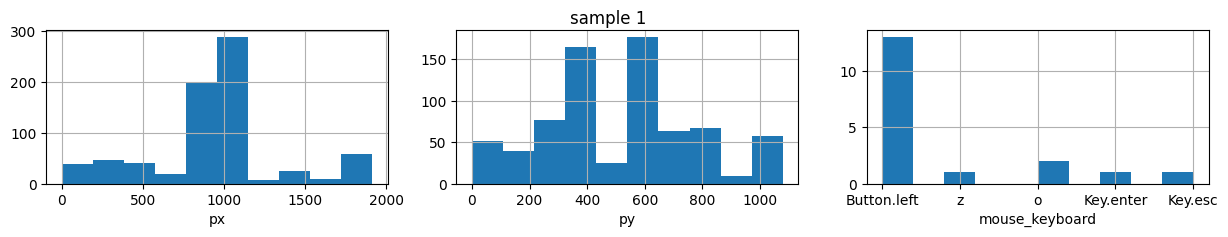

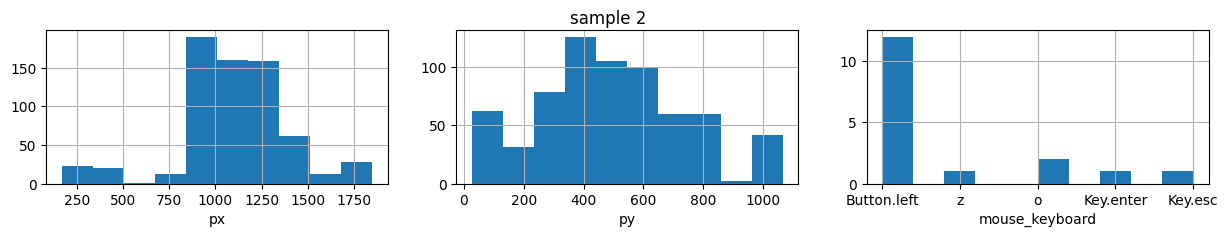

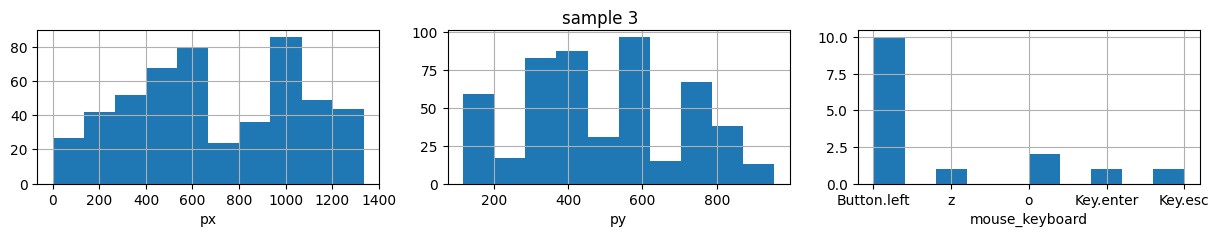

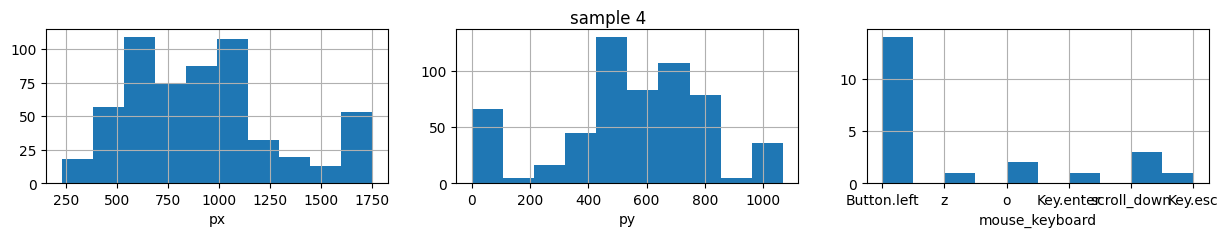

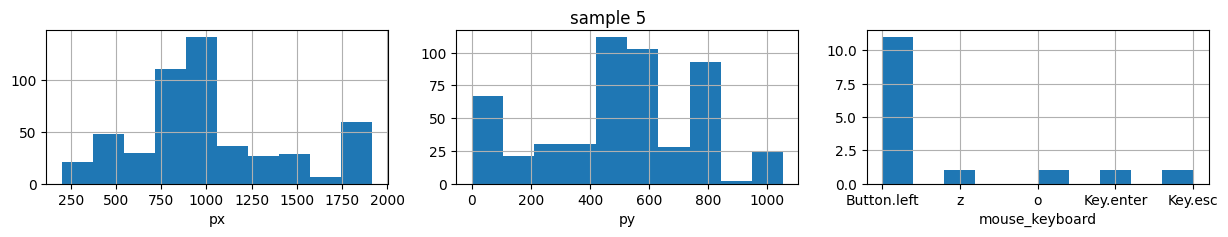

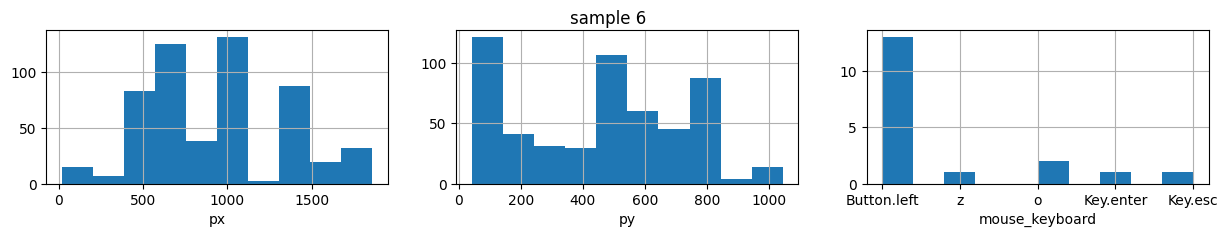

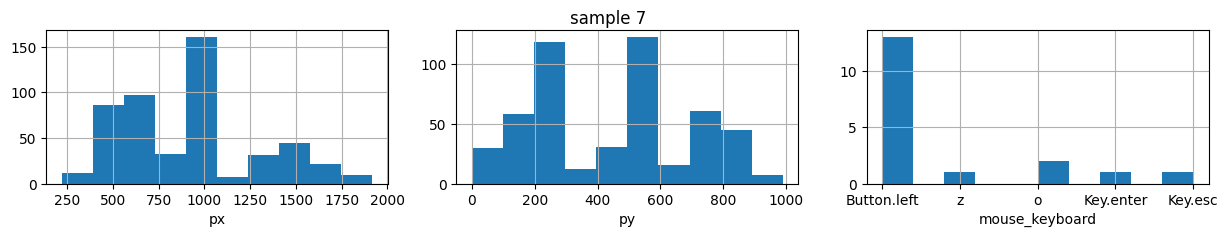

In [6]:
import matplotlib.pyplot as plt

for i, sample_df in enumerate(samples, 1):
    plt.figure(figsize=(15,2))
    plt.suptitle(f'sample {i}')
    for i,kname in enumerate(['px', 'py', 'mouse_keyboard']):
        plt.subplot(1,3,i+1)
        sample_df[kname].hist()
        plt.xlabel(kname)
    
    plt.plot()

In [7]:
# Replace None values with a string
for sample in samples:
    sample.fillna("no action",inplace=True)

# tokenization
tokens = set()
for sample in samples:
    tokens.update(sample['mouse_keyboard'].unique().tolist())
tokens = list(tokens)
tokens.sort()
print(len(tokens))
print(tokens)

7
['Button.left', 'Key.enter', 'Key.esc', 'no action', 'o', 'scroll_down', 'z']


In [8]:
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super().__init__()
        self.conv1 = nn.Conv2d(3,32,4, stride=2, padding="valid")
        self.conv2 = nn.Conv2d(32,64,4, stride=2, padding="valid")
        self.conv3 = nn.Conv2d(64,128,4, stride=2, padding="valid")
        self.conv4 = nn.Conv2d(128,256,4, stride=2, padding="valid")
        self.fc_mean = nn.Linear(256*2*2, latent_dims)
        self.fc_logvar = nn.Linear(256*2*2, latent_dims)

        self.N = torch.distributions.normal.Normal(torch.tensor(0.0).to(device), 
                                                   torch.tensor(1.0).to(device))
        self.kl = 0
    
    def forward(self, x):
        #x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = torch.flatten(x, 1)
        z_mu = self.fc_mean(x)
        z_logvar = self.fc_logvar(x)
        z_sigma = torch.exp(0.5*z_logvar)
        
        z = z_mu + z_sigma*self.N.sample(z_mu.shape)
        self.kl = 0.5*(z_sigma**2 + z_mu**2 - z_logvar - 1).sum()
        return z

class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latent_dims, 1024),
            nn.ReLU(True),
            nn.Unflatten(1,(1024,1,1)),
            nn.ConvTranspose2d(1024,128,5, stride=2, padding=0),
            nn.ReLU(True),
            nn.ConvTranspose2d(128,64,5, stride=2, padding=0),
            nn.ReLU(True),
            nn.ConvTranspose2d(64,32,6, stride=2, padding=0),
            nn.ReLU(True),
            nn.ConvTranspose2d(32,3,6, stride=2, padding=0),
            nn.Tanh(),
        )
    
    def forward(self, x):
        return self.decoder(x)

class Vae(nn.Module):
    def __init__(self, latent_dims):
        super().__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        # x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)

import torch

SEED = 0
d = 32

torch.manual_seed(SEED)
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# print(f'device: {device}')

device = "cpu"
vae = Vae(latent_dims=d)
vae.to(device)
vae.load_state_dict(torch.load('best_vae.pt')['model_state_dict'])
vae.eval()
vae.encoder

Encoder(
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=valid)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=valid)
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=valid)
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=valid)
  (fc_mean): Linear(in_features=1024, out_features=32, bias=True)
  (fc_logvar): Linear(in_features=1024, out_features=32, bias=True)
)

In [9]:
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision
from torchvision import transforms
import os
from torchvision.io import read_image
from PIL import Image

def normalization(x, max):
    return 2.0*(x/max) - 1.0

IMGSIZE= [64,64] #[1080//10, 1920//10]
img_transform = transforms.Compose([
                transforms.Resize(IMGSIZE, antialias=None),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                    std=[0.5, 0.5, 0.5]),
                
                ])

class PCDataset(Dataset):
    def __init__(self, samples, root_dir, encoder, transform, tokens):
        self.samples = samples
        self.root_dir = root_dir
        self.transform = transform
        self.encoder = encoder
        self.tokens = tokens
        self.maxtokens = len(tokens)
        self.maxlength = None
        self.maxwidth_screenshoot = None
        self.maxheight_screenshoot = None

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        features_list = []
        for i, img_path in enumerate(self.samples[idx]["img_path"]):
            # Image features
            image = Image.open(os.path.join(self.root_dir, img_path))
            image = self.transform(image)
            with torch.no_grad():
                img_features = self.encoder(torch.unsqueeze(image, 0))[0]

            # Cursor positions and Mouse-keyboars events
            px = self.samples[idx]["px"][i]
            py = self.samples[idx]["py"][i]
            event = self.tokens.index(self.samples[idx]["mouse_keyboard"][i])
            other_features = [normalization(px, max=self.maxwidth_screenshoot), 
                              normalization(py, max=self.maxheight_screenshoot),
                              normalization(event, max=self.maxtokens)]
            other_features = torch.tensor(other_features)
            features = torch.cat((img_features, other_features), 0)
            features_list.append(features)

        # Padding
        padding_dims = self.maxlength-len(features_list)
        features_list.extend(torch.zeros(torch.Size([padding_dims]) + features.shape))

        features = torch.stack(features_list, 0).type(torch.FloatTensor)
        zt0 = features[:-1,:]
        zt1 = features[1:,:]   
        return zt0, zt1
    
t_batch_size = 5
dataset = PCDataset(samples, root_dir='./', encoder=vae.encoder, transform=img_transform, tokens=tokens)
dataset.maxlength = 800
dataset.maxwidth_screenshoot = 1920
dataset.maxheight_screenshoot = 1080
#m = len(dataset)
traindata, valdata = torch.utils.data.random_split(dataset,[5, 2])
trainloader = torch.utils.data.DataLoader(traindata, batch_size=t_batch_size, shuffle=True, num_workers=10)
valloader = torch.utils.data.DataLoader(valdata, batch_size=2, shuffle=False, num_workers=10)

In [10]:
x0,y0 = next(iter(trainloader))
x = torch.permute(x0, (1,0,2))
y = torch.permute(y0, (1,0,2))
print(x.shape, y.shape)

torch.Size([799, 5, 35]) torch.Size([799, 5, 35])


In [38]:
class LSTM(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.lstm = nn.LSTM(z_dim, z_dim)
        self.fc_out = nn.Linear(z_dim, z_dim)

    def forward(self, zt):
        zt = torch.permute(zt, (1,0,2))
        yt, _ = self.lstm(zt)
       # yt = torch.permute(yt, (1,0,2))
        print(yt.size())
        zt_next = self.fc_out(yt.view(35, -1))
        return zt_next

In [39]:
model = LSTM(35)
out = model(x)

torch.Size([799, 5, 35])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (35x3995 and 35x35)

In [19]:
model = LSTM(35)

with torch.no_grad():
    x,_ = next(iter(trainloader))
    out = model(x)
print(out.shape)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (799x175 and 35x35)

In [13]:
def train_epoch(model, device, dataloader, optimizer):
    model.train()
    train_loss = 0.0
    for zt0, zt1 in dataloader: 
        zt0 = zt0.to(device)
        zt1 = zt1.to(device)
        zt1_pred = model(zt0)
        loss = ((zt1 - zt1_pred)**2).sum()

        model.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()
    return train_loss/len(dataloader.dataset)

def test_epoch(model, device, dataloader):
    model.eval()
    val_loss = 0.0
    with torch.no_grad(): 
        for zt0, zt1 in dataloader: 
            zt0 = zt0.to(device)
            zt1 = zt1.to(device)
            zt1_pred = model(zt0)
            loss = ((zt1 - zt1_pred)**2).sum() 
            val_loss += loss.item()
    return val_loss/len(dataloader.dataset)

In [14]:
import wandb

wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ezamorag (cic_lab). Use `wandb login --relogin` to force relogin


True

In [60]:
# Training from scratch
SEED = 0
lr = 0.1
epoch0 = 0
num_epochs = 100

torch.manual_seed(SEED)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'device: {device}')
model = LSTM(35)
model.to(device)
optim = torch.optim.Adam(model.parameters(), lr=lr)
best_valloss = float('Inf')

device: cuda


In [61]:
from IPython.display import clear_output

run = wandb.init(project="vae-pc", 
                 #name='2000 epochs', 
                 #entity='cic20',
                 mode="disabled", 
                 config={
                    "image_size": IMGSIZE,
                    "input_transform": img_transform, 
                    #"vae_latent_dims": d,
                    "learning_rate": lr,
                    "epochs": num_epochs,
                    "batch_size": trainloader.batch_size,
                    "seed": SEED, 
                 },
)
wandb.watch(model, log_freq=100)

trainloss, valloss = [], []
for epoch in range(epoch0, epoch0+num_epochs):
   trainloss.append(train_epoch(model,device,trainloader,optim))
   valloss.append(test_epoch(model,device,valloader))
   if valloss[-1] < best_valloss: 
      best_valloss = valloss[-1]
      torch.save({'epoch': epoch,
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optim.state_dict(),
                  'trainloss': trainloss[-1],
                  'valloss': valloss[-1],},
                  'best_lstm.pt')
   print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,trainloss[-1],valloss[-1]))
   #clear_output(wait=True) if (epoch + 1) % 10 == 0 else None
   wandb.log({"t_loss": trainloss[-1], "v_loss": valloss[-1]})


 EPOCH 1/100 	 train loss 19456.531 	 val loss 18244.414

 EPOCH 2/100 	 train loss 18925.822 	 val loss 17879.379

 EPOCH 3/100 	 train loss 18376.958 	 val loss 17826.146

 EPOCH 4/100 	 train loss 18264.009 	 val loss 17473.996

 EPOCH 5/100 	 train loss 18092.114 	 val loss 17387.369

 EPOCH 6/100 	 train loss 17819.105 	 val loss 17503.693

 EPOCH 7/100 	 train loss 17838.064 	 val loss 17334.236

 EPOCH 8/100 	 train loss 17564.464 	 val loss 17228.875

 EPOCH 9/100 	 train loss 17560.705 	 val loss 16955.717

 EPOCH 10/100 	 train loss 17542.013 	 val loss 16974.852

 EPOCH 11/100 	 train loss 17366.492 	 val loss 17091.855

 EPOCH 12/100 	 train loss 17314.394 	 val loss 16617.816

 EPOCH 13/100 	 train loss 17262.359 	 val loss 16788.080

 EPOCH 14/100 	 train loss 17081.494 	 val loss 16712.254

 EPOCH 15/100 	 train loss 17145.098 	 val loss 16708.719

 EPOCH 16/100 	 train loss 17161.728 	 val loss 16488.957

 EPOCH 17/100 	 train loss 16938.325 	 val loss 16623.266

 EPOC

best val_loss = 15504.197265625 at epoch = 84


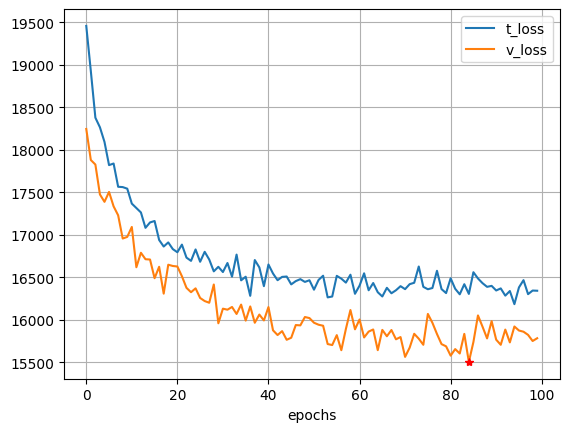

In [62]:
import numpy as np

ep_opt = np.argmin(np.asarray(valloss))
plt.plot(trainloss, label='t_loss')
plt.plot(valloss, label='v_loss')
plt.plot(ep_opt, valloss[ep_opt], 'r*')
plt.grid('on')
plt.xlabel('epochs')
plt.legend()
print(f'best val_loss = {valloss[ep_opt]} at epoch = {ep_opt}')
plt.show()

wandb.log({"best_val_loss": valloss[ep_opt], "best_epoch": ep_opt})

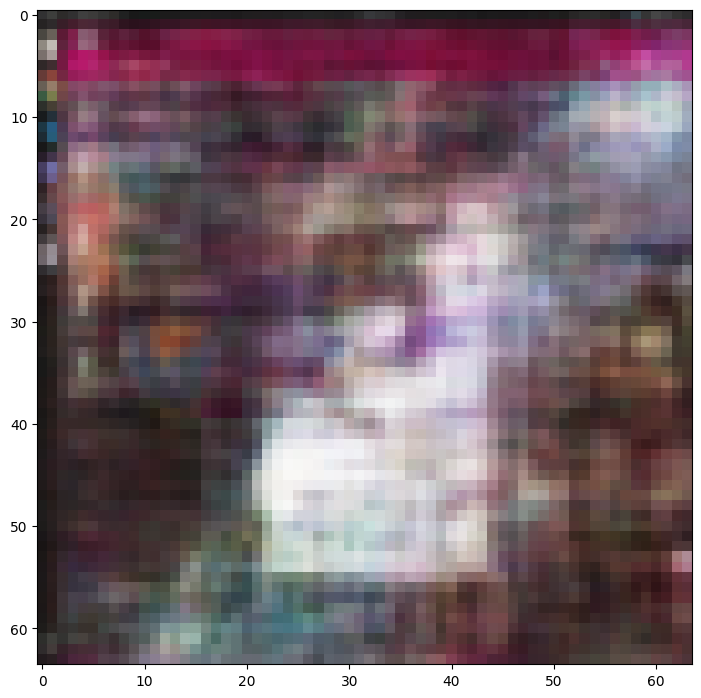

In [16]:
import numpy as np 

lstm_best = LSTM(35)
lstm_best.to(device)
lstm_best.load_state_dict(torch.load('best_lstm.pt')['model_state_dict'])

def unnormalized(xtensor):
    return np.transpose((xtensor*0.5+0.5).numpy(), (1, 2, 0))

with torch.no_grad():
    zt,_ = next(iter(valloader))
    z0 = zt[0,0,:].view(1,1,-1).to(device)
    for i in range(20):
        z1 = model(z0)
        z0 = z1
    latent = z1[0,0,:32].view(1,-1)
    img_recon = vae.decoder(latent.cpu())
    img_recon = img_recon.cpu()
    mosaic = torchvision.utils.make_grid(img_recon.data[:100],10,5)
    fig, ax = plt.subplots(figsize=(20, 8.5))
    plt.imshow(unnormalized(mosaic))
    plt.show()


In [17]:
print(latent.max(), latent.min(), latent.mean())

tensor(0.0600) tensor(-0.0612) tensor(0.0113)


In [74]:
z0 = zt[0,0,:].view(1,1,-1).to(device)
z1 = model(z0)
z1[0,0,:32].view(1,-1).shape

torch.Size([1, 32])

In [ ]:
    latent = z1[]
    img_recon = vae.decoder(latent)
    img_recon = img_recon.cpu()
    mosaic = torchvision.utils.make_grid(img_recon.data[:100],10,5)
    fig, ax = plt.subplots(figsize=(20, 8.5))
    plt.imshow(unnormalized(mosaic))
    plt.show()

wandb.log({"decoded_random_latents": wandb.Image(unnormalized(mosaic))})

IMPORTANTE checar el rango de valors de salida de lstm conlos de entrenamiento